In [1]:
from matplotlib.pyplot import axes
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"


def prepare_data(
    dataset,
    num_imgs=10,
    preprocess_sensory=True,
    noise_level="medium",
    use_fix=False,
):
    import torch
    import random

    data = dataset.data
    # print(num_imgs)
    # print(data.shape)
    data = data.reshape(data.shape[0], -1)
    # print(data.shape)
    data = torch.tensor(data[:num_imgs]).float().to(device)
    # print(data.shape)

    # data = random.sample(dataset.data.flatten(1).float().to("cpu"), num_imgs)
    if preprocess_sensory:
        if use_fix:
            for i in range(len(data)):
                data[i] = (data[i] - data[i].mean()) / data[i].std()
        else:
            data = (data - data.mean()) / data.std()
    # noissing the data
    if noise_level == "none":
        return data, data
    elif noise_level == "low":
        random_noise = torch.zeros_like(data).uniform_(-1, 1)
    elif noise_level == "medium":
        random_noise = torch.zeros_like(data).uniform_(-1.25, 1.25)
    elif noise_level == "high":
        random_noise = torch.zeros_like(data).uniform_(-1.5, 1.5)
    noisy_data = data + random_noise

    return data, noisy_data

In [2]:
import numpy as np
import torch
from nd_scaffold import GridScaffold, SparseMatrixBySparsityInitializer
from graph_utils import graph_scaffold, print_imgs_side_by_side
from matrix_initializers import SparseMatrixByScalingInitializer
from vectorhash_functions import solve_mean, spacefillingcurve
import math
from scipy.stats import norm


def test_memory_capacity(
    data,
    noisy_data,
    shapes=[(3, 3, 5), (4, 4, 7)],
    N_h=1000,
    initalization_method="by_scaling",
    percent_nonzero_relu=0.01,
    W_gh_var=1.0,
    sparse_initialization=0.1,
    T=0.01,
    continualupdate=False,
    ratshift=False,
    initialize_W_gh_with_zeroes=False,
    pseudo_inverse=False,
    learned_pseudo=True,
    plot_figs=False,
):
    assert initalization_method in ["by_scaling", "by_sparsity"]

    if initalization_method == "by_scaling":
        W_hg_std = math.sqrt(W_gh_var)
        W_hg_mean = (
            -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(shapes))
        )
        h_normal_mean = len(shapes) * W_hg_mean
        h_normal_std = math.sqrt(len(shapes)) * W_hg_std
        relu_theta = 0
    elif initalization_method == "by_sparsity":
        gamma = 1 - sparse_initialization
        relu_theta = math.sqrt(gamma * len(shapes)) * norm.ppf(1 - percent_nonzero_relu)
        W_hg_mean = 0
        W_hg_std = math.sqrt(gamma * len(shapes))
        h_normal_mean = -relu_theta
        h_normal_std = (1 - sparse_initialization) * len(shapes)

    GS = GridScaffold(
        shapes=shapes,
        N_h=N_h,
        input_size=data.shape[1],
        device=device,
        h_normal_mean=h_normal_mean,
        h_normal_std=h_normal_std,
        sparse_matrix_initializer=(
            SparseMatrixByScalingInitializer(
                mean=W_hg_mean, scale=W_hg_std, device=device
            )
            if initalization_method == "by_scaling"
            else SparseMatrixBySparsityInitializer(
                sparsity=sparse_initialization, device=device
            )
        ),
        relu_theta=relu_theta,
        T=T,
        continualupdate=continualupdate,
        ratshift=ratshift,
        initialize_W_gh_with_zeroes=initialize_W_gh_with_zeroes,
        pseudo_inverse=pseudo_inverse,
        learned_pseudo=learned_pseudo,
        epsilon=0.01,
        use_h_fix=True,
        MagicMath=False,
    )

    # learn over all images
    v = spacefillingcurve(shapes)

    a = GS.learn_path(observations=data, velocities=v[: len(data)])
    print(a)
    # print(len(v[: len(data)]))
    recalled_imgs = GS.recall(noisy_data)
    # if plot_figs:
    #     for i in range(len(data)):
    #         original_img = data[i].reshape(28, 28).cpu().numpy()
    #         noisy_img = noisy_data[i].reshape(28, 28).cpu().numpy()
    #         recalled_img = recalled_imgs[i].reshape(28,28).cpu().numpy()
    #         print_imgs_side_by_side(
    #             original_img,
    #             noisy_img,
    #             recalled_img,
    #             out=f"mnist_test_2/{len(data)}shitty{i}.png",
    #             captions=["original", "noisy", "recalled"],
    #             title="Learned",
    #         )

    similarity = torch.nn.functional.cosine_similarity(data, recalled_imgs)
    return similarity, a
    # return GS.H - GS.mean_h

Recreating Capacity Results

In [3]:
# Memory Capacity Tests
import torchvision
from torchvision import transforms
import torch

shapes = [(3, 3), (4, 4), (5, 5)]
# shapes = [(5, 5), (9, 9), (11, 11)]

N_h = 1000

N_g = 0
for shape in shapes:
    l = torch.prod(torch.tensor(shape)).item()
    N_g += l
# print("N_g", N_g)


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
)
dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

# dataset = torchvision.datasets.FashionMNIST(
#     root="data", train=True, download=True, transform=transform
# )

# dataset = torchvision.datasets.CIFAR100(
#   root="data", train=True, download=True, transform=transform
# )

input_size = 1
for shape in dataset.data[0].shape:
    input_size *= shape

theoretical_capacity = N_g * N_h / input_size  # 784 is the size of the input for MNIST

percents = [
    0.5,
    # 0.01,  # 1
    # 0.03,  # 2
    # 0.1,  # 3
    # 0.2,  # 4
    # 0.33,  # 5
    # 0.5,  # 6
    # 0.75,  # 7
    # 0.9,  # 8
    # 1.0,  # 9
    # 1.1,  # 10
    # 1.5,  # 11
    # 2.0,  # 12
    # 3.0,  # 13
    # 10.0,  # 14
]

num_images = [theoretical_capacity * p for p in percents]
num_images = [math.ceil(n) for n in num_images]
print(num_images)
num_images = [500]
preprocess_sensory = True
noise_level = "none"

# TODO: Need a hyperparam N_p for dimension of the projection from grid cells to place cells
similarities = []
for num_imgs in num_images:
    print("==========================================")
    data, noisy_data = prepare_data(
        dataset,
        num_imgs=num_imgs,
        preprocess_sensory=preprocess_sensory,
        noise_level=noise_level,
    )
    similarity, a = test_memory_capacity(
        data,
        noisy_data,
        shapes=shapes,
        N_h=N_h,
        initalization_method="by_scaling",
        percent_nonzero_relu=0.8,  # 800 / N_h,
        W_gh_var=1.0,
        sparse_initialization=0,
        T=0.0001,
        continualupdate=False,
        ratshift=False,
        initialize_W_gh_with_zeroes=False,
        pseudo_inverse=False,
        learned_pseudo=True,
        plot_figs=True,
    )
    print("Cosine Similarity", torch.mean(similarity).item())
    similarities.append(similarity)


[32]
module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  1000
image 1
Unique Hs seen while recalling: 1
Unique Gs seen while recalling (before denoising): 1
Unique Gs seen while recalling (after denoising): 1
Unique Hs seen while recalling (after denoising): 1
avg nonzero H: 783.0
avg nonzero H_denoised: 783.0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
first H is G 0 times W_hg tensor([ True,  True, False,  True,  True,  True, False,  True,  True, False,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True, False,  True,  True,  True,  True,
         True,  T

/var/folders/q_/hxdspxw938n3_89qddxh_2fm0000gp/T/ipykernel_88711/1004324384.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data[:num_imgs]).float().to(device)
/Users/Ile-Maurice/Desktop/rl-research-main/rl-research/vectorhash/nd_scaffold.py:547: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  1 + input.T @ self.inhibition_matrix_hs @ input


Unique Hs seen while recalling: 1
Unique Gs seen while recalling (before denoising): 1
Unique Gs seen while recalling (after denoising): 1
Unique Hs seen while recalling (after denoising): 1
avg nonzero H: 997.0
avg nonzero H_denoised: 823.0
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
first H is G 0 times W_hg tensor([ True,  True, False,  True,  True,  True, False,  True,  True, False,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True, Fal

In [4]:
print(a)

[tensor([0.0000e+00, 5.0078e+00, 4.5451e+00, 1.2904e+00, 3.9800e+00, 2.2005e+00,
        1.8015e+00, 7.5266e-03, 1.8957e+00, 4.7802e+00, 0.0000e+00, 5.0291e+00,
        1.7190e+00, 3.1859e+00, 4.4714e-01, 0.0000e+00, 5.3572e+00, 0.0000e+00,
        3.6737e+00, 0.0000e+00, 1.3561e+00, 1.3576e+00, 2.0117e+00, 0.0000e+00,
        2.5375e+00, 5.4085e+00, 3.4469e+00, 1.1389e+00, 6.1179e-01, 0.0000e+00,
        3.4118e-01, 0.0000e+00, 5.4584e-01, 1.6075e+00, 0.0000e+00, 2.6009e+00,
        0.0000e+00, 7.4956e-01, 2.6314e-01, 1.8672e+00, 2.9158e+00, 2.4334e+00,
        6.0887e+00, 1.9144e+00, 1.3768e+00, 2.5843e+00, 0.0000e+00, 4.2090e-01,
        1.7850e+00, 9.1990e-01, 4.0650e+00, 3.7558e+00, 1.5801e+00, 0.0000e+00,
        2.5446e+00, 0.0000e+00, 0.0000e+00, 8.7800e-02, 1.0377e+00, 2.7636e+00,
        1.5214e+00, 0.0000e+00, 6.2684e-01, 2.9391e+00, 1.5822e+00, 4.6314e+00,
        1.1382e+00, 4.6243e-01, 0.0000e+00, 3.7674e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.1700e+00, 1.4128e

In [5]:
coords = []
coords1 = []
from vectorhash_functions import ConvertToXYNew, GraphGrid, ConvertXtoYOld
for i in range(11):
    v = (a[i+1][:9])
    print(a[i+1])
    norm = [float(i)/sum(v) for i in v]
    coords.append(ConvertToXYNew((torch.tensor(v)), [3, 3]))

for i in range(11):
    v = (a[i+1][:9])
    norm = [float(i)/sum(v) for i in v]
    coords1.append(ConvertToXYNew(torch.nn.functional.softmax(torch.tensor(v/0.01)), [3, 3]))

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([351.0728, 340.6371, 325.5696, 316.0058, 307.5377, 310.0135, 318.7710,
        308.2735, 311.8558, 192.4204, 189.5524, 181.0587, 191.4576, 175.7012,
        180.5151, 174.7276, 176.8610, 174.7013, 179.0965, 173.5137, 184.4025,
        178.1503, 180.2762, 179.4326, 177.8696, 127.1376, 118.8790, 125.9704,
        117.6201, 115.2349, 113.8770, 113.9112, 112.6628, 116.0490, 112.8256,
        116.6005, 112.1811, 115.2942, 112.1148, 114.9085, 114.9305, 112.9316,
        116.2097, 115.0948, 113.8799, 115.8403, 113.5674, 114.9276, 114.7296,
        112.3588])
tensor([392.2629, 398.5936, 363.5235, 360.9808, 349.1186, 351.5543, 362.9850,
        350.9117, 354.7682, 218.4535, 212.9323, 213.1687, 213.2415, 199.5596,
        204.9722, 198.9735, 201.6029, 198.6258, 203.19

/var/folders/q_/hxdspxw938n3_89qddxh_2fm0000gp/T/ipykernel_88711/110836044.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coords.append(ConvertToXYNew((torch.tensor(v)), [3, 3]))
/var/folders/q_/hxdspxw938n3_89qddxh_2fm0000gp/T/ipykernel_88711/110836044.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coords1.append(ConvertToXYNew(torch.nn.functional.softmax(torch.tensor(v/0.01)), [3, 3]))
/var/folders/q_/hxdspxw938n3_89qddxh_2fm0000gp/T/ipykernel_88711/110836044.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  coords1.append(ConvertToXYNew(torch.nn.functional.softmax(torch.tensor(v/0.01)), [3, 3]))

In [6]:
print(coords)
print(coords1)

[(tensor(0.5000), tensor(0.5000)), (tensor(1.4799), tensor(1.4580)), (tensor(1.4789), tensor(1.4596)), (tensor(1.4794), tensor(1.4581)), (tensor(1.4708), tensor(1.4567)), (tensor(1.4805), tensor(1.4587)), (tensor(1.4846), tensor(1.4588)), (tensor(1.4742), tensor(1.4790)), (tensor(1.4800), tensor(1.4817)), (tensor(1.4824), tensor(1.4858)), (tensor(1.4858), tensor(1.4827))]
[(tensor(0.5000), tensor(0.5000)), (tensor(0.5000), tensor(0.5000)), (tensor(1.5000), tensor(0.5000)), (tensor(0.5000), tensor(0.5000)), (tensor(0.5000), tensor(0.5000)), (tensor(1.5000), tensor(0.5000)), (tensor(0.5000), tensor(0.5000)), (tensor(0.5000), tensor(1.5000)), (tensor(0.5000), tensor(1.5000)), (tensor(0.5000), tensor(1.5000)), (tensor(0.5000), tensor(1.5000))]


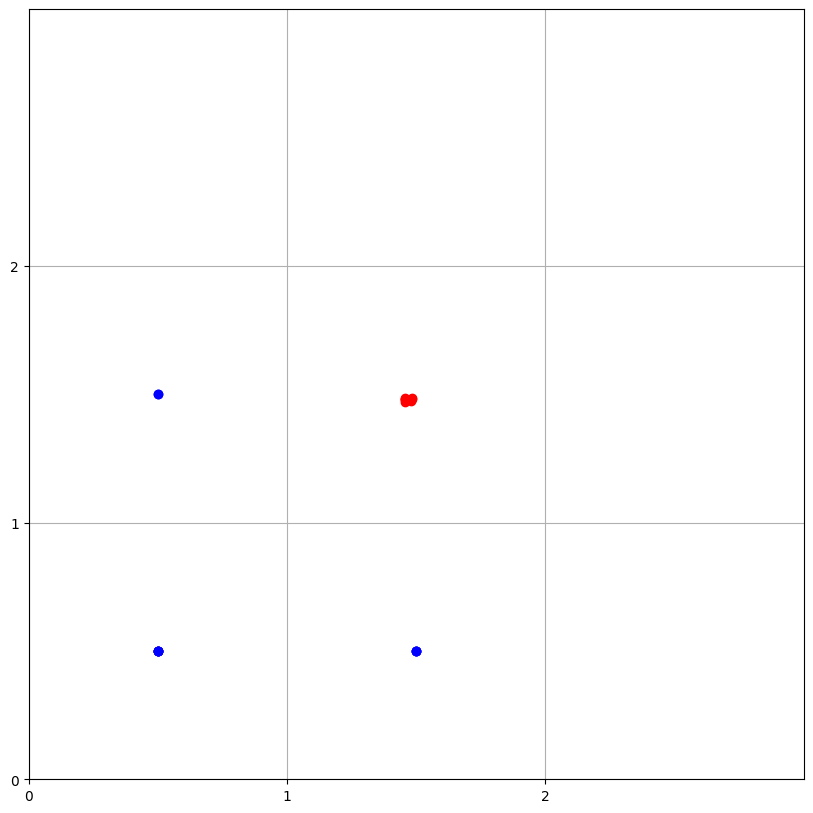

In [7]:
GraphGrid((3,3), [coords, coords1])

In [31]:
s = torch.randn(784, 3600)
h = torch.randn(1000, 3600)
torch.einsum('ik,jk->ij', s, h)
s = torch.randn(3600, 784)
h = torch.randn(3600, 1000)
print(h)
torch.einsum('ki,kj->ij', s, h)

tensor([[-0.9268,  0.0913, -1.3761,  ...,  0.4258,  1.1942,  2.3004],
        [ 1.0246, -1.3140,  0.4752,  ...,  1.2768,  0.5890, -0.3331],
        [-1.8125,  0.4028, -0.6515,  ..., -0.0821, -0.1035,  0.0296],
        ...,
        [-0.0977,  0.7757, -0.4005,  ..., -1.2526, -0.9745, -1.2563],
        [ 0.3763,  0.7320,  0.5781,  ...,  0.5566, -0.7452,  1.3120],
        [-0.2478, -1.3210,  0.6815,  ...,  0.9485, -1.1108,  0.1712]])


tensor([[  31.6383,   31.7681,   41.5228,  ...,  -33.3386, -112.9757,
         -103.9389],
        [ 107.3475,  -26.0707,   37.2067,  ...,   18.1913, -110.2103,
           38.3090],
        [  51.6647,  -39.7410,   47.6991,  ...,  112.8209,   78.6437,
           40.1364],
        ...,
        [  69.9083, -138.4404,  -57.5548,  ..., -117.9315,  -36.0614,
           48.6986],
        [ -53.6648,    3.8953,  -62.1000,  ...,  -53.0791,  -52.0722,
           88.2547],
        [   7.0583,  -27.6674,  -38.9957,  ...,   63.3000,   -3.1053,
          -63.2319]])

Comparing initialization techniques (at 10%, 50%, 100%, 150% capacity)

Compare continual learning vs learning once at start (at 10%, 50%, 100%, 150% capacity)

Hyperparam tuning for number active hippocampal cells after denoising

Testing valididy and recall of learned pseudoinverse

In [8]:
# Init of psuedo inverse calculation
import torchvision
from torchvision import transforms
import torch
from torch import nn


class PsuedoInverse:
    def __init__(self, N_h, input_size, epsilon=0.01, device="cpu"):
        self.N_h = N_h
        self.input_size = input_size
        self.epsilon = epsilon
        self.device = device

        self.inhibition_matrix_sh = torch.eye(self.N_h, device=device) / (N_h)
        self.inhibition_matrix_hs = torch.eye(self.input_size, device=device) / (
            input_size
        )

        # INITIALIZATION OF HIDDEN LAYER MAGIC

        self.lin1HS = nn.Linear(input_size, 10 * input_size)
        self.activationHS = nn.LogSigmoid()
        torch.nn.init.uniform_(self.lin1HS.weight, -0.5, 0.5)

        self.lin1SH = nn.Linear(N_h, 10 * N_h)
        self.activationSH = nn.LogSigmoid()
        torch.nn.init.uniform_(self.lin1HS.weight, -0.5, 1 / 2)

        self.W_sh = torch.zeros((self.input_size, self.N_h), device=device)
        self.W_hs = torch.zeros((self.N_h, self.input_size), device=device)

    def hiddenlayer(self, input, learned="hs"):
        if learned == "hs":
            hidden = self.activationHS(self.lin1HS(input))
        else:
            hidden = self.activationSH(self.lin1SH(input))
        return hidden

    def calculatepseudoinverse(self, input, output, input_size, learned="hs"):
        inhibition = (
            self.inhibition_matrix_hs if learned == "hs" else self.inhibition_matrix_sh
        )
        W = self.W_hs if learned == "hs" else self.W_sh

        bk = (inhibition @ input) / (1 + input.T @ inhibition @ input)

        # ERROR VECTOR EK
        E_k = output - W @ input

        # NORMALIZATION FACTOR

        E = ((E_k.T @ E_k) / input_size) / (1 + input.T @ inhibition @ input)
        L2Enorm = torch.abs(E)

        # GAMMA CALCULATION

        gamma = 1 / (1 + ((1 - torch.exp(-L2Enorm)) / self.epsilon))

        inhibition = inhibition - inhibition * input @ bk.T
        # ((1-torch.exp(-L2Enorm))/self.epsilon) * torch.eye(input_size, device=self.device)

        if learned == "hs":
            self.inhibition_matrix_hs = inhibition
            self.W_hs += torch.outer((output - W @ input), bk.T)
        else:
            self.inhibition_matrix_sh = inhibition
            self.W_sh += torch.outer((output - W @ input), bk.T)

    def learnprojection(self, input, output, learned="hs"):
        # input: (N)
        # output: (M)
        # M: (M x N)
        # Eg : Wgh = 1/Nh * sum_i (G_i * H_iT) (outer product)
        ret = (torch.einsum("j,i->ji", output, input)) / (
            # self.N_h
            torch.linalg.norm(input + 1e-10)
            ** 2
        )
        if learned == "hs":
            self.W_hs += ret
        else:
            self.W_sh += ret

    def learn(self, input, output, learned="hs"):

        # input = self.hiddenlayer(input, learned)

        self.calculatepseudoinverse(input, output, self.input_size, learned)

    def recall(self, input, used="hs"):
        W = self.W_hs if used == "hs" else self.W_sh
        # return W @ self.hiddenlayer(input, used)
        return W @ input

In [9]:
import torchvision
from torchvision import transforms
import torch
from scipy.stats import norm

shapes = [(3, 3), (4, 4), (5, 5)]
# shapes = [(5, 5), (9, 9), (11, 11)]

N_h = 1000

N_g = 0
for shape in shapes:
    l = torch.prod(torch.tensor(shape)).item()
    N_g += l
# print("N_g", N_g)


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
)
dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

# dataset = torchvision.datasets.FashionMNIST(
#     root="data", train=True, download=True, transform=transform
# )

# dataset = torchvision.datasets.CIFAR100(
#   root="data", train=True, download=True, transform=transform
# )

input_size = 1
for shape in dataset.data[0].shape:
    input_size *= shape

theoretical_capacity = N_g * N_h / input_size  # 784 is the size of the input for MNIST


num_images = 300
print(num_images)

preprocess_sensory = True
noise_level = "none"
data, noisy_data = prepare_data(
    dataset,
    num_imgs=num_images,
    preprocess_sensory=preprocess_sensory,
    noise_level=noise_level,
)
H = test_memory_capacity(
    data,
    data,
    shapes=shapes,
    N_h=N_h,
    initalization_method="by_scaling",
    percent_nonzero_relu=200 / N_h,
    W_gh_var=1.0,
    sparse_initialization=0,
    T=0.01,
    continualupdate=False,
    ratshift=False,
    initialize_W_gh_with_zeroes=False,
    pseudo_inverse=False,
    learned_pseudo=False,
    plot_figs=False,
)


300
module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  1000
image 1
Unique Hs seen while recalling: 1
Unique Gs seen while recalling (before denoising): 1
Unique Gs seen while recalling (after denoising): 1
Unique Hs seen while recalling (after denoising): 1
avg nonzero H: 214.0
avg nonzero H_denoised: 214.0
tensor([1.0000e+00, 3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44,
        3.7835e-44, 3.7835e-44, 3.7835e-44, 1.0000e+00, 3.7835e-44, 3.7835e-44,
        3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44,
        3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44,
        3.7835e-44, 1.0000e+00, 3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44,
        3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44,
        3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44,
        3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44, 3.7835e-44,
        3.7835e-44,

/var/folders/q_/hxdspxw938n3_89qddxh_2fm0000gp/T/ipykernel_88711/1004324384.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data[:num_imgs]).float().to(device)


tensor([0.6576])
G = G_ tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True]])
G = first g tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True]])
G_ = first g tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True,

In [10]:
from matplotlib import pyplot as plt
# For each G, The first 9 entries are a 3x3 grid, the next 16 are a 4x4 grid, and the last 25 are a 5x5 grid. I want you to take the first 9 entries and reshape them into a 3x3 grid, the next 16 into a 4x4 grid, and the last 25 into a 5x5 grid. Then I want you to make an array with the grids in the order of 3x3, 4x4, 5x5. Then I want you to store all the versions of the 3x3 matrix, the 4x4 and the 5x5
A= G.cpu().numpy()

mat3 = []
mat4 = []
mat5 = []

for i in A:
    mat3.append(i[:9].reshape(3,3))
    mat4.append(i[9:25].reshape(4,4))
    mat5.append(i[25:].reshape(5,5))

# check all possible combinations of 3x3, 4x4, 5x5 matrices and see if there are any that are the same or that all possible combinations have been computed
# from the 3x3, 4x4, 5x5 matrices

for i in range(len(mat3)):
    for j in range(len(mat4)):
        for k in range(len(mat5)):
            if i == j and j == k and i == k:
                print(i,j,k)
  






NameError: name 'G' is not defined

In [ ]:
pseudoinverse = PsuedoInverse(N_h=1000, input_size=784, epsilon=0.01)
n = 100
dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

data, noisydata = prepare_data(
    dataset,
    num_imgs=n,
    preprocess_sensory=True,
    noise_level="medium",
)


for i in range(1):
    for i in range(n):
        pseudoinverse.learn(data[i], H[i], learned="hs")
        pseudoinverse.learn(H[i], data[i], learned="sh")

img_reconstruction = []
H_reconstruction = []
recompfromboth = []

print("RECALL")
for i in range(n):
    recompfromboth.append(
        torch.cosine_similarity(
            data[i],
            pseudoinverse.recall(
                input=pseudoinverse.recall(input=data[i], used="hs"), used="sh"
            ),
            dim=0,
        )
    )
    # append(torch.cosine_similarity(H[i], pseudoinverse.recall(input=noisydata[i], used="hs"), dim=0))
    H_reconstruction.append(
        torch.cosine_similarity(
            H[i], pseudoinverse.recall(input=data[i], used="hs"), dim=0
        )
    )
    img_reconstruction.append(
        torch.cosine_similarity(data[i], pseudoinverse.recall(H[i], used="sh"), dim=0)
    )

print("Data mean", torch.mean(torch.tensor(data)))
print("H mean", torch.mean(torch.tensor(H)))
print("Num images", n)
print("H Reconstruction", torch.mean(torch.tensor(H_reconstruction)))
print("Img Reconstruction", torch.mean(torch.tensor(img_reconstruction)))
print("Recomp from both", torch.mean(torch.tensor(recompfromboth)))

/var/folders/q_/hxdspxw938n3_89qddxh_2fm0000gp/T/ipykernel_79239/1004324384.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data[:num_imgs]).float().to(device)


NameError: name 'H' is not defined

In [ ]:
import torchvision
from torchvision import transforms
import torch
import math
import numpy as np
from matrix_initializers import ConstantInitializer, SparseMatrixByScalingInitializer
from vectorhash_functions import solve_mean, spacefillingcurve
from nd_scaffold import GridScaffold
from graph_utils import print_imgs_side_by_side
import matplotlib.pyplot as plt
import os
import torchvision
from torchvision import transforms
from scipy.stats import norm

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
)
dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)
data, noisy_data = prepare_data(
    dataset,
    num_imgs=100,
    preprocess_sensory=True,
    noise_level="none",
)

T = 1e-3
device = "cpu"
shapes = [(3, 3), (4, 4), (5, 5)]
N_h = 1000
target_N_h = 300
percent_nonzero_relu = target_N_h / N_h

W_hg_std = 1
W_hg_mean = -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(shapes))
h_normal_mean = len(shapes) * W_hg_mean
h_normal_std = math.sqrt(len(shapes)) * W_hg_std

const = ConstantInitializer(
    value=GridScaffold(
        shapes=shapes,
        N_h=N_h,
        input_size=data.shape[1],
        device=device,
        h_normal_mean=h_normal_mean,
        h_normal_std=h_normal_std,
        sparse_matrix_initializer=SparseMatrixByScalingInitializer(
            mean=W_hg_mean, scale=W_hg_std, device=device
        ),
        relu_theta=0,
        T=T,
        use_h_fix=True,
        learned_pseudo=True,
        initialize_W_gh_with_zeroes=False,
    ).W_hg
)

GS = GridScaffold(
    shapes=shapes,
    N_h=N_h,
    input_size=data.shape[1],
    device=device,
    h_normal_mean=h_normal_mean,
    h_normal_std=h_normal_std,
    sparse_matrix_initializer=const,
    relu_theta=0,
    T=T,
    use_h_fix=True,
    learned_pseudo=True,
    initialize_W_gh_with_zeroes=False,
)
GS2 = GridScaffold(
    shapes=shapes,
    N_h=N_h,
    input_size=data.shape[1],
    device=device,
    h_normal_mean=h_normal_mean,
    h_normal_std=h_normal_std,
    sparse_matrix_initializer=const,
    relu_theta=0,
    T=T,
    use_h_fix=False,
    learned_pseudo=True,
    initialize_W_gh_with_zeroes=False,
)


# GS.learn_path(observations=data, velocities=v[: len(data)])
# recalled_imgs = GS.recall(noisy_data)
# similarity = torch.nn.functional.cosine_similarity(data, recalled_imgs)
# print(torch.mean(similarity).item())

v = spacefillingcurve(shapes)
print(torch.vstack(v))
k = 0

GS.learn(data[k], velocity=v[k])
GS2.learn(data[k], velocity=v[k])
print(k)
k += 1

for i in range(0, k):
    print(i)
    s = data[i]
    h = GS.hippocampal_from_sensory(s)
    g = GS.grid_from_hippocampal(h)
    g_rec = GS.denoise(g)
    h_rec = GS.hippocampal_from_grid(g_rec)
    s_rec = GS.sensory_from_hippocampal(h_rec - GS.mean_h)
    print(g_rec)
    print("h_mean:", (h_rec.mean() - GS.mean_h).item())
    print("loss:", torch.nn.functional.mse_loss(s, s_rec).item())
    print("similarity:", torch.cosine_similarity(s, s_rec).mean().item())


fig, ax = plt.subplots(k, 6, figsize=(15, 4 * k))
for j in range(0, k):
    h1 = GS.hippocampal_from_sensory(data[j])
    h2 = GS2.hippocampal_from_sensory(data[j])

    recovered_s1 = GS.sensory_from_hippocampal(h1 - GS.mean_h)
    recovered_s2 = GS2.sensory_from_hippocampal(h2)

    g_recovered_s1 = GS.grid_from_hippocampal(h1)
    g_recovered_s2 = GS2.grid_from_hippocampal(h2)

    g_recovered_s1_1 = GS.sensory_from_hippocampal(
        (GS.hippocampal_from_grid(GS.denoise(g_recovered_s1))) - GS.mean_h
    )
    g_recovered_s1_2 = GS2.sensory_from_hippocampal(
        (GS2.hippocampal_from_grid(GS2.denoise(g_recovered_s2)))
    )

    ax[j][0].imshow(data[j].reshape(28, 28).cpu().numpy())
    ax[j][0].set_title(f"s{j}")
    ax[j][1].imshow(recovered_s1.reshape(28, 28).cpu().numpy())
    ax[j][1].set_title("s -> h -> s")
    ax[j][2].imshow(recovered_s2.reshape(28, 28).cpu().numpy())
    ax[j][2].set_title("s -> h -> s\n (no fix)")
    ax[j][3].imshow(g_recovered_s1_1.reshape(28, 28).cpu().numpy())
    ax[j][3].set_title("s -> h -> g -> denoised g -> h -> s")
    ax[j][4].imshow(g_recovered_s1_2.reshape(28, 28).cpu().numpy())
    ax[j][4].set_title("s -> h -> g -> denoised g -> h -> s \n(no fix)")
    ax[j][5].imshow(
        (
            -g_recovered_s1_1 / g_recovered_s1_1.mean()
            + g_recovered_s1_2 / g_recovered_s1_2.mean()
        )
        .reshape(28, 28)
        .cpu()
        .numpy()
    )
    ax[j][5].set_title("diff")

    plt.show()

    fig.savefig("test_fix_4.png")

In [7]:
from torch import abs, norm
def Rk1MrUpdate(A, A_pinv, c, d, Zero_tol, Case_Print_Flag):
    # size c = [n,1]
    # size d = [m,1]
    c = c.reshape(-1,1)
    d = d.reshape(-1,1)
    n = c.shape[0]
    m = d.shape[0]
    V = A_pinv @ c

    b = 1 + d.T @ V
    N = A_pinv.T @ d
    W = (torch.eye(n) - A @ A_pinv) @ c
    M = (torch.eye(m) - A_pinv @ A) @ d
    ## squared norm of the two abovesaid vectors
    w_snorm = norm(W,p=2)**2   
    m_snorm = norm(M,p=2)**2

    if w_snorm>=Zero_tol and m_snorm>=Zero_tol:
        if Case_Print_Flag == 1:
            print('case 1')
        G = ((-1/w_snorm) * V @ W.T) - ((1/m_snorm) * (M @ N.T)) + ((b/m_snorm/w_snorm) * (M @ W.T))

    elif w_snorm<Zero_tol and m_snorm>=Zero_tol and abs(b)<Zero_tol:
        if Case_Print_Flag == 1:
            print('case 2')  
        v_snorm = norm(V,2)**2     
        G = (-1/v_snorm) * (V @ V.T) @ A_pinv -(1/m_snorm) * M @ N.T
    
    elif w_snorm<Zero_tol and abs(b)>Zero_tol:
        if Case_Print_Flag == 1:
            print('case 3')
        v_snorm = norm(V,2)**2
        G = ((1/b) * M @ V.T @ A_pinv - (b/(v_snorm * m_snorm + b**2))) @ ((v_snorm / b) * M + V) @ ((m_snorm / b) * A_pinv.T @ V + N).T        
    
    elif m_snorm<Zero_tol and w_snorm>=Zero_tol and abs(b)<Zero_tol:
        if Case_Print_Flag == 1:
            print('case 4')
        n_snorm = norm(N,2)**2
        G = (-1/n_snorm) * A_pinv @ (N @ N.T) -(1/ w_snorm) * V @ W.T
                                     
    elif m_snorm<Zero_tol and abs(b)>Zero_tol:
        if Case_Print_Flag == 1:
            print('case 5')        
        n_snorm = norm(N,2)**2 
        a1 = (1/b) * A_pinv @ N @ W.T
        a2 = (b/(w_snorm * n_snorm + b**2)) * ((w_snorm/b) * A_pinv @ N + V)
        a3 = ((n_snorm/b) * W + N).T
        G = ((1/b) * A_pinv @ N @ W.T) - (((b/(w_snorm * n_snorm + b**2)) * ((w_snorm/b) * A_pinv @ N + V)) @ (((n_snorm/b) * W + N).T))

    elif m_snorm<Zero_tol and w_snorm<Zero_tol and abs(b)<Zero_tol:
        if Case_Print_Flag == 1:
            print('case 6')
        v_snorm = norm(V,2)**2
        n_snorm = norm(N,2)**2
        G = (-1/v_snorm) * (V @ V.T) @ A_pinv - (1/n_snorm) * A_pinv @ (N @ N.T) + (((V.T @ A_pinv @ N) / (v_snorm * n_snorm)) @ (V @ N.T))

    A_pinv_New = A_pinv + G
    return A_pinv_New



In [8]:
a = "norm"
use_h_fix = True



@torch.no_grad()
def calculate_update_Wsh_fix( input: torch.Tensor, output: torch.Tensor) -> torch.Tensor:
    if use_h_fix:
        return calculate_update(input=input - GS.mean_h, output=output)
    else:
        return calculate_update(input=input, output=output)

@torch.no_grad()
def calculate_update( input: torch.Tensor, output: torch.Tensor) -> torch.Tensor:
        # input: (N)
        # output: (M)
        # M: (M x N)
        # Eg : Wgh = 1/Nh * sum_i (G_i * H_iT) (outer product)
    if a == "norm":
        scale = torch.linalg.norm(input) ** 2
    elif a == "n_h":
        scale = GS.N_h
    else:
        raise ValueError("Invalid calculate_update_scaling_method")

    ret = torch.einsum("j,i->ji", output, input) / (scale + 1e-10)
    return ret
    

In [ ]:
print(GS.G[9])

In [5]:
from matplotlib import pyplot as plt
torch.manual_seed(0)
i_Dim = 1000
o_Dim = 784
inputs = []
outputs = []
n = 3000

# H -= GS.mean_h

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
)
dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

# dataset = torchvision.datasets.FashionMNIST(
#     root="data", train=True, download=True, transform=transform
# )

# dataset = torchvision.datasets.CIFAR100(
#   root="data", train=True, download=True, transform=transform
# )

input_size = 1
for shape in dataset.data[0].shape:
    input_size *= shape

theoretical_capacity = N_g * N_h / input_size  # 784 is the size of the input for MNIST


num_images = n
print(num_images)

preprocess_sensory = True
noise_level = "none"
data, noisy_data = prepare_data(
    dataset,
    num_imgs=num_images,
    preprocess_sensory=preprocess_sensory,
    noise_level=noise_level,
    use_fix=True,
)


ps = PsuedoInverse(N_h=1000, input_size=784, epsilon=0.01)

for i in range(n):
    inputs.append(torch.randn(i_Dim))
    outputs.append(torch.randn(o_Dim))


outputs = data

A_pinv = torch.eye(o_Dim, i_Dim)
A = torch.pinverse(A_pinv)

loss = nn.MSELoss()

Ccossim_learned_s_to_h = []
Ccossim_recall_s_to_h = []
Ccossim_learned_h_to_s = []
Ccossim_recall_h_to_s = []

Ccossim_learned_s_to_hPS = []
Ccossim_recall_s_to_hPS = []
Ccossim_learned_h_to_sPS = []
Ccossim_recall_h_to_sPS = []

Mcossim_learned_s_to_h = []
Mcossim_recall_s_to_h = []
Mcossim_learned_h_to_s = []
Mcossim_recall_h_to_s = []

Mcossim_learned_s_to_hPS = []
Mcossim_recall_s_to_hPS = []
Mcossim_learned_h_to_sPS = []
Mcossim_recall_h_to_sPS = []

IMAGERECONSTRUCTION = []

Hs = []

W_sh = torch.zeros((input_size, N_h), device=device)

figs = []

for i in range(n):
    A_pinv = Rk1MrUpdate(A, A_pinv, inputs[i], outputs[i], 3e-2, 0)

    # mean = torch.mean(A_pinv)
    # # perform pinverse call on cpu to avoid non terminating error

    # D = A_pinv
    # # check is nan in D
    # if torch.isnan(A_pinv).any():
    #     print("nan in D")
    #     break
    # # check is inf in D
    # if torch.isinf(A_pinv).any():
    #     print("inf in D")
    #     break
    # A = torch.pinverse(D)
    ps.learn(outputs[i], inputs[i], learned="hs")
    W_sh += calculate_update_Wsh_fix(inputs[i], outputs[i])
    ps.learn(inputs[i], outputs[i], learned="sh")
    # Ccossim_learned_s_to_hPS.append(torch.cosine_similarity(outputs[i], ps.recall(input=inputs[i], used="sh"), dim=0))
    Ccossim_learned_s_to_hPS.append(torch.cosine_similarity(inputs[i], ps.recall(input=outputs[i], used="hs"), dim=0))
    Ccossim_learned_h_to_sPS.append(torch.cosine_similarity(outputs[i], W_sh @ inputs[i], dim=0))

    # Mcossim_learned_s_to_hPS.append(loss(outputs[i], ps.recall(input=inputs[i], used="sh")))
    Mcossim_learned_s_to_hPS.append(loss(inputs[i], ps.recall(input=outputs[i], used="hs")))
    Mcossim_learned_h_to_sPS.append(loss(outputs[i], W_sh @ inputs[i]))

    # cossim_learned_s_to_h.append(torch.cosine_similarity(inputs[i], A @ outputs[i], dim=0))
    # cossim_learned_h_to_s.append(torch.cosine_similarity(outputs[i], A_pinv @ inputs[i], dim=0))


    # print("mean A", torch.mean(A))
    # print("mean non zero A", torch.mean(A[A != 0]))
    # print(A[0])
    if i % 50 == 0:
        for o in range(1):
            Hs.append(ps.recall(outputs[o], used="hs"))
            # print next to each other with plot
            fig, ax = plt.subplots(1, 5, figsize=(15, 4))
            ax[0].imshow(outputs[o].reshape(28, 28).cpu().numpy())
            ax[0].set_title("Original Image")
            ax[1].imshow((W_sh @ (inputs[o])).reshape(28, 28).cpu().numpy())
            meanhippo = ps.recall((outputs[o]), used="hs")
            #meanhippo = meanhippo - torch.mean(meanhippo)
            ax[1].set_title(" HEBB RECALLED Image H -> S")
            ax[2].imshow((ps.recall((inputs[o]), used="sh")).reshape(28, 28).cpu().numpy())
            ax[2].set_title("PS RECALLED Image H -> S")
            ax[3].imshow((W_sh @ (meanhippo)).reshape(28, 28).cpu().numpy())
            ax[3].set_title("Hebb Recalled Image S -> H -> S")
            ax[4].imshow((ps.recall((meanhippo), used="sh")).reshape(28, 28).cpu().numpy())
            ax[4].set_title("PS Recalled Image S -> H -> S")
            # plt title 
            fig.tight_layout()
            fig.suptitle("STEP " + str(i))
            figs.append(fig)
            print("Mean of W_sh Hebb",torch.mean(W_sh))
            print("Mean of W_sh PS", torch.mean(ps.W_sh))

# show all the figures on top of each other
for fig in figs:
    plt.show()

for i in range(n):
    # cossim_recall_s_to_h.append(torch.cosine_similarity(inputs[i], A @ outputs[i], dim=0))
    # cossim_recall_h_to_s.append(torch.cosine_similarity(outputs[i], A_pinv @ inputs[i], dim=0))

    Ccossim_recall_s_to_hPS.append(torch.cosine_similarity(inputs[i], ps.recall(input=outputs[i], used="hs"), dim=0))
    # Ccossim_recall_h_to_sPS.append(torch.cosine_similarity(inputs[i], ps.recall(input=outputs[i], used="hs"), dim=0))
    Ccossim_recall_h_to_sPS.append(torch.cosine_similarity(outputs[i], W_sh @ inputs[i], dim=0))

    Mcossim_recall_s_to_hPS.append(loss(inputs[i], ps.recall(input=outputs[i], used="hs")))
    # Mcossim_recall_h_to_sPS.append(loss(inputs[i], ps.recall(input=outputs[i], used="hs")))
    Mcossim_recall_h_to_sPS.append(loss(outputs[i], W_sh @ inputs[i]))

    IMAGERECONSTRUCTION.append(torch.cosine_similarity(outputs[i], ps.recall((ps.recall((outputs[i]), used="hs")), used="sh"), dim=0))


print("Cossim")

print("Mean Learned S to H", torch.mean(torch.tensor(Ccossim_learned_s_to_hPS)))
print("Mean Recall S to H", torch.mean(torch.tensor(Ccossim_recall_s_to_hPS)))
print("Mean Learned H to S", torch.mean(torch.tensor(Ccossim_learned_h_to_sPS)))
print("Mean Recall H to S", torch.mean(torch.tensor(Ccossim_recall_h_to_sPS)))

print("MSE LOSS")

print("Mean Learned S to H", torch.mean(torch.tensor(Mcossim_learned_s_to_hPS)))
print("Mean Recall S to H", torch.mean(torch.tensor(Mcossim_recall_s_to_hPS)))
print("Mean Learned H to S", torch.mean(torch.tensor(Mcossim_learned_h_to_sPS)))
print("Mean Recall H to S", torch.mean(torch.tensor(Mcossim_recall_h_to_sPS)))

print("RAHHHHHHHH")
print("Mean Image Reconstruction", torch.mean(torch.tensor(IMAGERECONSTRUCTION)))

# print 5 random images, reconstructed vs not 


#         for i in range(1):
#             # print next to each other with plot
#             fig, ax = plt.subplots(1, 5, figsize=(15, 4))
#             ax[0].imshow(outputs[i].reshape(28, 28).cpu().numpy())
#             ax[0].set_title("Original Image")
#             ax[1].imshow((W_sh @ (inputs[i])).reshape(28, 28).cpu().numpy())
#             meanhippo = ps.recall((outputs[i]), used="hs")
#             meanhippo = meanhippo - torch.mean(meanhippo)
#             print(torch.mean(meanhippo))
#             ax[1].set_title(" HEBB RECALLED Image H -> S")
#             ax[2].imshow((ps.recall((inputs[i]), used="sh")).reshape(28, 28).cpu().numpy())
#             ax[2].set_title("PS RECALLED Image H -> S")
#             ax[3].imshow((W_sh @ (meanhippo)).reshape(28, 28).cpu().numpy())
#             ax[3].set_title("PS Recalled Image S -> H -> S")
#             ax[4].imshow((ps.recall((meanhippo), used="sh")).reshape(28, 28).cpu().numpy())
#             ax[4].set_title("Hebb Recalled Image S -> H -> S")
#             # plt title 
#             plt.title("STEP " + str(i))
#             plt.show()





3000


/var/folders/q_/hxdspxw938n3_89qddxh_2fm0000gp/T/ipykernel_79239/1004324384.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data[:num_imgs]).float().to(device)


NameError: name 'PsuedoInverse' is not defined


NO FIX, 300 IMAGES, INHIBITION PSEUDO INVERSE, 1000 Nh

cos sim Learned a S TO H tensor(0.9826)    
cos sim Recall a S TO H tensor(0.9010)    RECALL        S --> H
cos sim Learned b H TO S tensor(0.8408)    
cos sim Recall b H TO S tensor(0.2089)    RECALL         H --> S
mse loss Learned a PS tensor(0.2577)
mse loss Recall a PS tensor(0.3314)        RECALL         S --> H
mse loss Learned b PS tensor(0.3707)
mse loss Recall b PS tensor(1.3567)        RECALL         H --> S


YES FIX, 300 IMAGES, INHIBITION PSEUDO INVERSE, 1000 Nh
cos sim Learned a S TO H tensor(0.9837)
cos sim Recall a S TO H tensor(0.9151)     RECALL        S --> H
cos sim Learned b H TO S tensor(0.9013)
cos sim Recall b H TO S tensor(0.3045)     RECALL       H --> S
mse loss Learned a PS tensor(0.2583)
mse loss Recall a PS tensor(0.3276)       RECALL         S --> H
mse loss Learned b PS tensor(0.3087)
mse loss Recall b PS tensor(0.9600)       RECALL        H --> S

above is STD AND MEAN


NO FIX, 300  RNDM, INHIBTION PSEUDO INVERSE, 1000 NH

cos sim Learned a S TO H tensor(0.9825)
cos sim Recall a S TO H tensor(0.9057)
cos sim Learned b H TO S tensor(0.9775)
cos sim Recall b H TO S tensor(0.8788)
mse loss Learned a PS tensor(0.2577)
mse loss Recall a PS tensor(0.3327)
mse loss Learned b PS tensor(0.2651)
mse loss Recall b PS tensor(0.3619)



FIX, 300 IMGS, JUST MEAN
cos sim Learned a S TO H tensor(0.9908)
cos sim Recall a S TO H tensor(0.7363)
cos sim Learned b H TO S tensor(0.9515)
cos sim Recall b H TO S tensor(0.3840)
mse loss Learned a PS tensor(1.2398)
mse loss Recall a PS tensor(1.6315)
mse loss Learned b PS tensor(0.1746)
mse loss Recall b PS tensor(0.8690)


FIX, 300 IMGS, JUST STD

cos sim Learned a S TO H tensor(0.9851)
cos sim Recall a S TO H tensor(0.9173)
cos sim Learned b H TO S tensor(0.3782)
cos sim Recall b H TO S tensor(-0.0012)
mse loss Learned a PS tensor(0.2769)
mse loss Recall a PS tensor(0.3495)
mse loss Learned b PS tensor(1.7704e+10)
mse loss Recall b PS tensor(7.5863e+10)


In [ ]:
# make 5 bar graphs with Different methods and y the cosine similarity and another y the MSE loss
# there will be 5 METHODS : for each method there will be 4 bar for cossim (s->h, h->s) (learned and recall mean) and 4 bar for mse loss (s->h, h->s) (learned and recall mean)
# first method is no fix, 300 imgs, second is yes fix mean and std, 300 imgs, thrid is 300 rnd imgs no fix, fourth is 300 imgs fix only mean, fifth is 300 imgs fix only std

# data to plot
# NO FIX, 300 IMAGES, INHIBITION PSEUDO INVERSE, 1000 Nh

# cos sim Learned a S TO H tensor(0.9826)    
# cos sim Recall a S TO H tensor(0.9010)    RECALL        S --> H
# cos sim Learned b H TO S tensor(0.8408)    
# cos sim Recall b H TO S tensor(0.2089)    RECALL         H --> S
# mse loss Learned a PS tensor(0.2577)
# mse loss Recall a PS tensor(0.3314)        RECALL         S --> H
# mse loss Learned b PS tensor(0.3707)
# mse loss Recall b PS tensor(1.3567)        RECALL         H --> S

data1 = [[[0.9826, 0.9010], [0.8408, 0.2089]], [[0.2577, 0.3314], [0.3707, 1.3567]]]


# YES FIX, 300 IMAGES, INHIBITION PSEUDO INVERSE, 1000 Nh
# cos sim Learned a S TO H tensor(0.9837)
# cos sim Recall a S TO H tensor(0.9151)     RECALL        S --> H
# cos sim Learned b H TO S tensor(0.9013)
# cos sim Recall b H TO S tensor(0.3045)     RECALL       H --> S
# mse loss Learned a PS tensor(0.2583)
# mse loss Recall a PS tensor(0.3276)       RECALL         S --> H
# mse loss Learned b PS tensor(0.3087)
# mse loss Recall b PS tensor(0.9600)       RECALL        H --> S

data2 = [[[0.9837, 0.9151], [0.9013, 0.3045]], [[0.2583, 0.3276], [0.3087, 1.9600]]]

# above is STD AND MEAN


# NO FIX, 300  RNDM, INHIBTION PSEUDO INVERSE, 1000 NH

# cos sim Learned a S TO H tensor(0.9825)
# cos sim Recall a S TO H tensor(0.9057)
# cos sim Learned b H TO S tensor(0.9775)
# cos sim Recall b H TO S tensor(0.8788)
# mse loss Learned a PS tensor(0.2577)
# mse loss Recall a PS tensor(0.3327)
# mse loss Learned b PS tensor(0.2651)
# mse loss Recall b PS tensor(0.3619)

data3 = [[[0.9825, 0.9057], [0.9775, 0.8788]], [[0.2577, 0.3327], [0.2651, 0.3619]]]



# FIX, 300 IMGS, JUST MEAN
# cos sim Learned a S TO H tensor(0.9908)
# cos sim Recall a S TO H tensor(0.7363)
# cos sim Learned b H TO S tensor(0.9515)
# cos sim Recall b H TO S tensor(0.3840)
# mse loss Learned a PS tensor(1.2398)
# mse loss Recall a PS tensor(1.6315)
# mse loss Learned b PS tensor(0.1746)
# mse loss Recall b PS tensor(0.8690)

data4 = [[[0.9908, 0.7363], [0.9515, 0.3840]], [[1.2398, 1.6315], [0.1746, 0.8690]]]


# FIX, 300 IMGS, JUST STD

# cos sim Learned a S TO H tensor(0.9851)
# cos sim Recall a S TO H tensor(0.9173)
# cos sim Learned b H TO S tensor(0.3782)
# cos sim Recall b H TO S tensor(-0.0012)
# mse loss Learned a PS tensor(0.2769)
# mse loss Recall a PS tensor(0.3495)
# mse loss Learned b PS tensor(1.7704e+10)
# mse loss Recall b PS tensor(7.5863e+10)

methods = ["NO FIX, 300 IMAGES, INHIBITION PSEUDO INVERSE, 1000 Nh", "YES FIX, 300 IMAGES, INHIBITION PSEUDO INVERSE, 1000 Nh", "NO FIX, 300  RNDM, INHIBTION PSEUDO INVERSE, 1000 NH", "FIX, 300 IMGS, JUST MEAN", "FIX, 300 IMGS, JUST STD, 1000 Nh"]

data5 = [[[0.9851, 0.9173], [0.3782, -0.0012]], [[0.2769, 0.3495], [1.7704e+10, 7.5863e+10]]]

data = [data1, data2, data3, data4, data5]

import matplotlib.pyplot as plt

# create plot
fig, ax = plt.subplots(5, 2, figsize=(15, 20))
index = np.arange(1)
bar_width = 0.15
opacity = 0.8

for i in range(5):
    # print first method
    for o in range(2):
        p = data[i]
        # first two bars are learned and recall for s -> h
        ax[i][o].bar(index, p[o][0][0], bar_width, alpha=opacity, color='b', label='Learned')
        ax[i][o].bar(index + bar_width, p[o][0][1], bar_width, alpha=opacity, color='r', label='Recall')
        
        # second two bars are learned and recall for h -> s
        ax[i][o].bar(index + 2*bar_width, p[o][1][0], bar_width, alpha=opacity, color='b', label='Learned')
        ax[i][o].bar(index + 3*bar_width, p[o][1][1], bar_width, alpha=opacity, color='r', label='Recall')



    # add another y label for mse scale
    
    ax[i][0].set_xlabel('COSINE SIMILARITY \n' + methods[i])
    ax[i][0].set_ylabel('Cossine Similarity')
    ax[i][0].set_xticklabels(('COSINE SIMILARITY S--> H', 'COSINE SIMILARITY H-->S'))
    ax[i][0].legend()

    ax[i][1].set_xlabel('MSE LOSS\n' + methods[i])
    ax[i][1].set_ylabel('MSE LOSS')
    ax[i][1].set_xticklabels(('MSE LOSS S--> H', 'MSE LOSS H-->S'))
    ax[i][1].legend()



# space out the plots more
plt.tight_layout()




plt.show()





In [ ]:
# A = 1 2 0 1
# 0 1 -1 0
# O 0 1 -l
A = torch.tensor([[1, 2, 0, 1], [0, 1, -1, 0], [0, 0, 1, -1]])
A_pinv = (1/12) * torch.tensor([[3, -3, 0], [3, 5, 4], [3, -7, 4], [3, -7, -8]])
c = torch.tensor([1, 2, 3, 4])
d = torch.tensor([1, 2, 3, 4])
A_pinv = Rk1MrUpdate(A, A_pinv, c, d, 1e-14, 0)

A_pinv @ c


In [93]:
import numpy as np
def gen_gbook(lambdas, Ng, Npos):
    ginds = [0,lambdas[0],lambdas[0]+lambdas[1]]; 
    gbook=np.zeros((Ng,Npos))
    for x in range(Npos):
        phis = np.mod(x,lambdas) 
        gbook[phis+ginds,x]=1 
    return gbook


In [ ]:
gbook = gen_gbook([3,4,5], (50), 1000)
print(gbook[0])